In [ ]:
%cd ..
    
import torch
import numpy as np
from models.nri import NRI, NRITrainingParams
from models.nri_PE import NRIWithPE
from models.grand import GraNRI
from models.train import CheckpointParameters, train, resume
from experiments.helper import get_dataset
import matplotlib.pyplot as plt

train_set, val_set, test_set, adj_mat, edge_prior = get_dataset(False)

# plot loss curves

In [ ]:
from matplotlib.ticker import MaxNLocator

nri_state = np.load('models/out/nri_final/checkpt_20.loss.npy', allow_pickle=True).item()
nri_pe_state = np.load('models/out/nri_pe_final/checkpt_20.loss.npy', allow_pickle=True).item()
grand_state = np.load('models/out/grand_final/checkpt_20.loss.npy', allow_pickle=True).item()

def plot_metrics(metric: str, title: str = None):
    fig, ax = plt.subplots()

    epochs = [*range(21)]

    ax.plot(epochs, nri_state[metric], 'o-', label='nri')
    ax.plot(epochs, nri_pe_state[metric], 'o-', label='nri-pe')
    ax.plot(epochs, grand_state[metric], 'o-', label='grand')
    ax.legend()

    if title is not None:
        ax.set_title(title)

    ax.set_xlim((0, 20))
    # set integer ticks: https://stackoverflow.com/a/34880501
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    return fig

plot_metrics('train_mse', 'Training MSE').show()
plot_metrics('valid_mse', 'Validation MSE').show()

# t-SNE plot

plot distribution of positional encoding of nri-pe with t-SNE

In [ ]:
from sklearn.manifold import TSNE
from data.preprocess import ASFParser

skeleton = ASFParser().parse('data/raw/35.asf.txt')

nri_pe = NRIWithPE(state_dim=6, prior_steps=50, hid_dim=128, adj_mat=adj_mat, do_prob=0.5)
nri_pe.load_state_dict(torch.load('models/out/nri_pe_final/best.pt', map_location=torch.device('cpu')))

enc_pe = nri_pe.encoder.positional_encoding.positional_embedding.detach().numpy()
dec_pe = nri_pe.decoder.positional_encoding.positional_embedding.detach().numpy()


enc_out = TSNE(2).fit_transform(enc_pe)
dec_out = TSNE(2).fit_transform(dec_pe)


fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

for i, joint in enumerate(skeleton.compute_seq):
    ax[0].plot(enc_out[i:(i+1), 0], enc_out[i:(i+1), 1], '.')
    ax[1].plot(dec_out[i:(i+1), 0], dec_out[i:(i+1), 1], '.')

for i, joint in enumerate(skeleton.compute_seq):
    ax[0].annotate(joint.name, (enc_out[i, 0], enc_out[i, 1]), fontsize=6)
    ax[1].annotate(joint.name, (dec_out[i, 0], dec_out[i, 1]), fontsize=6)

ax[0].set_title('encoder')
ax[1].set_title('decoder')
fig.suptitle('tSNE plot of positional encoding')

# Extrapolation Error

plot forecast error

In [2]:
from torch.utils.data import DataLoader
from tqdm import tqdm

nri = NRI(state_dim=6, prior_steps=50, hid_dim=128, adj_mat=adj_mat, do_prob=0.5)
nri.load_state_dict(torch.load('models/out/nri_final/best.pt', map_location=torch.device('cpu')))
nri.eval()

nri_pe = NRIWithPE(state_dim=6, prior_steps=50, hid_dim=128, adj_mat=adj_mat, do_prob=0.5)
nri_pe.load_state_dict(torch.load('models/out/nri_pe_final/best.pt', map_location=torch.device('cpu')))
nri_pe.eval()

grand = GraNRI(state_dim=6, prior_steps=50, hid_dim=256, adj_mat=adj_mat, do_prob=0.5)
grand.load_state_dict(torch.load('models/out/grand_final/best.pt', map_location=torch.device('cpu')))
grand.eval()

test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

all_nri_mse = np.zeros((len(test_loader), 49))
all_nri_pe_mse = np.zeros((len(test_loader), 49))
all_grand_mse = np.zeros((len(test_loader), 49))

for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
    data = data[:, :50, :]
    target = data[:, 1:, :]

    nri_pred, _ = nri(data, 49)
    nri_sq = (nri_pred - target) ** 2

    nri_pe_pred, _ = nri_pe(data, 49)
    nri_pe_sq = (nri_pe_pred - target) ** 2

    grand_pred, _ = grand(data, 49)
    grand_sq = (grand_pred - target) ** 2

    for step in range(49):
        all_nri_mse[idx, step] = nri_sq[:, step].mean().item()
        all_nri_pe_mse[idx, step] = nri_pe_sq[:, step].mean().item()
        all_grand_mse[idx, step] = grand_sq[:, step].mean().item()

100%|██████████| 296/296 [1:32:14<00:00, 18.70s/it]


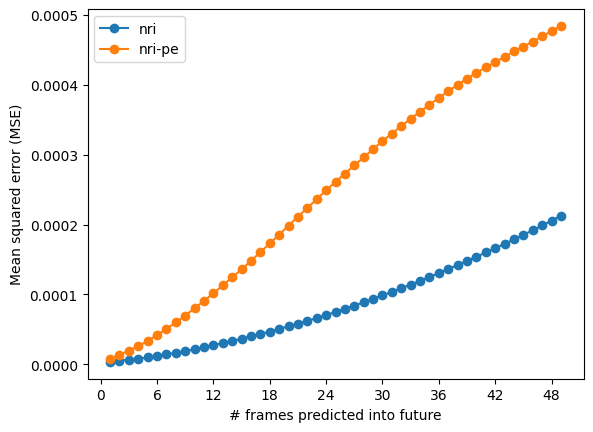

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

steps = [*range(1, 50)]
nri_mse = all_nri_mse.mean(axis=0)
nri_pe_mse = all_nri_pe_mse.mean(axis=0)
grand_mse = all_grand_mse.mean(axis=0)

ax.plot(steps, nri_mse, 'o-', label='nri')
ax.plot(steps, nri_pe_mse, 'o-', label='nri-pe')
#ax.plot(steps, grand_mse, 'o-', label='grand')

ax.set_ylabel('Mean squared error (MSE)')
ax.set_xlabel('# frames predicted into future')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()